In [1]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

In [2]:
datasets_folder = pathlib.Path("../../../Datasets")
dataset_name = "kdd2004.csv"
dataset_path = datasets_folder/dataset_name

if not dataset_path.exists():
    raise FileExistsError(f"The file indicated with {dataset_path.resolve()} doesn't exist")

In [3]:
df = pd.read_csv(dataset_path)

df["target"] = df["target"].map({-1:0, 1:1})

df.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
0,52.0,32.69,0.30,2.5,20.0,1256.8,-0.89,0.33,11.0,-55.0,...,1595.1,-1.64,2.83,-2.0,-50.0,445.2,-0.35,0.26,0.76,0
1,58.0,33.33,0.00,16.5,9.5,608.1,0.50,0.07,20.5,-52.5,...,762.9,0.29,0.82,-3.0,-35.0,140.3,1.16,0.39,0.73,0
2,77.0,27.27,-0.91,6.0,58.5,1623.6,-1.40,0.02,-6.5,-48.0,...,1491.8,0.32,-1.29,0.0,-34.0,658.2,-0.76,0.26,0.24,0
3,41.0,27.91,-0.35,3.0,46.0,1921.6,-1.36,-0.47,-32.0,-51.5,...,2047.7,-0.98,1.53,0.0,-49.0,554.2,-0.83,0.39,0.73,0
4,50.0,28.00,-1.32,-9.0,12.0,464.8,0.88,0.19,8.0,-51.5,...,479.5,0.68,-0.59,2.0,-36.0,-6.9,2.02,0.14,-0.23,0


In [4]:
df["target"].value_counts(normalize=True)

0    0.991108
1    0.008892
Name: target, dtype: float64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=["target"], axis=1),
    df["target"],
    test_size=0.3
)

X_train.shape, X_test.shape

((102025, 74), (43726, 74))

In [6]:
# Baseline prediction: predicting the majority class
y_train_baseline = pd.Series(np.zeros_like(y_train))
y_test_baseline = pd.Series(np.zeros_like(y_test))

In [7]:
# Random forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=2)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2)

In [8]:
# Logistic regression model
logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)

C:\Users\safou\anaconda3\envs\imbalanced_env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [9]:
# Baseline model
confusion_matrix(y_test, y_test_baseline)

array([[43332,     0],
       [  394,     0]], dtype=int64)

In [10]:
# Random forest
confusion_matrix(y_test, rf.predict(X_test))

array([[43331,     1],
       [  166,   228]], dtype=int64)

In [11]:
# Logistic regression
confusion_matrix(y_test, logit.predict(X_test))

array([[43314,    18],
       [  109,   285]], dtype=int64)

## FPR and FNR

In [12]:
confusion_matrix(y_test, y_test_baseline).ravel()

array([43332,     0,   394,     0], dtype=int64)

In [13]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_baseline).ravel()

fpr = fp / (tn + fp)
fnr = fn / (tp + fn)

print(f"False positive rate of the baseline model: {fpr}")
print(f"False negative rate of the baseline model: {fnr}")

False positive rate of the baseline model: 0.0
False negative rate of the baseline model: 1.0


In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, rf.predict(X_test)).ravel()

fpr = fp / (tn + fp)
fnr = fn / (tp + fn)

print(f"False positive rate of the random forest model: {fpr}")
print(f"False negative rate of the random forest model: {fnr}")

False positive rate of the random forest model: 2.307763315794332e-05
False negative rate of the random forest model: 0.4213197969543147


In [15]:
tn, fp, fn, tp = confusion_matrix(y_test, logit.predict(X_test)).ravel()

fpr = fp / (tn + fp)
fnr = fn / (tp + fn)

print(f"False positive rate of the logistic regression model: {fpr}")
print(f"False negative rate of the logistic regression model: {fnr}")

False positive rate of the logistic regression model: 0.0004153973968429798
False negative rate of the logistic regression model: 0.2766497461928934


In [16]:
pd.DataFrame(zip(["a", "b"], [1, 2]))

,0,1
0,a,1
1,b,2


In [17]:
thresholds = np.linspace(0, 1, 100)

fpr_list, fnr_list = [], []

logit_prob_preds = logit.predict_proba(X_test)[:, 1]

for threshold in thresholds:
    # The predicted classes
    preds = np.where(logit_prob_preds>=threshold, 1, 0)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # FNR and FPR
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)

    fnr_list.append(fnr)
    fpr_list.append(fpr)

metrics = pd.DataFrame(
    zip(fpr_list, fnr_list), 
    columns=["fpr", "fnr"],
    index=thresholds
)


In [18]:
metrics.head()

,fpr,fnr
0.000000,1.000000,0.000000
0.010101,0.037155,0.055838
0.020202,0.019939,0.088832
0.030303,0.013685,0.098985
0.040404,0.010200,0.104061


Text(0.5, 1.0, 'FPR & FNR vs. Probability threshold')

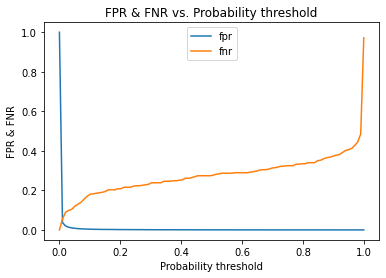

In [19]:
metrics.plot()
plt.xlabel("Probability threshold")
plt.ylabel("FPR & FNR")
plt.title("FPR & FNR vs. Probability threshold")